In [1]:
import os
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from transformers import CLIPProcessor, CLIPModel

IMAGE_FOLDER_PATH = "./data"   
MODEL_ID = "openai/clip-vit-base-patch32"
BATCH_SIZE = 32       
EPOCHS = 6           
LEARNING_RATE = 5e-6 
SAVE_PATH = "./fine_tuned_clip_model"
device = "cpu"

In [2]:
def get_clean_label(filename):
    clean = filename.replace("_", " ").replace("-", " ")
    return re.sub(r'\d+', '', clean).strip()

def create_dataset_list(file_list):
    data = []
    classes = set()
    for f in file_list:
        label = get_clean_label(f.stem)
        data.append({
            "image_path": str(f),
            "caption": f"a photo of a {label}",
            "label": label
        })
        classes.add(label)
    return data, sorted(list(classes))

path_obj = Path(IMAGE_FOLDER_PATH)
all_files = sorted(list(set(list(path_obj.glob("*.jpg")) + list(path_obj.glob("*.JPG")))))


train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42, shuffle=True)

train_data, _ = create_dataset_list(train_files)
test_data, class_names = create_dataset_list(test_files)

In [3]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item['image_path']).convert("RGB")
        
        inputs = self.processor(
            text=[item['caption']], 
            images=image, 
            return_tensors="pt", 
            padding="max_length", 
            truncation=True
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "pixel_values": inputs["pixel_values"].squeeze(0)
        }

In [4]:
train_acc_history = []
test_acc_history = []
loss_history = []

processor = CLIPProcessor.from_pretrained(MODEL_ID)
model_ft = CLIPModel.from_pretrained(MODEL_ID).to(device)

for param in model_ft.vision_model.parameters():
    param.requires_grad = False

train_ds = ImageCaptionDataset(train_data, processor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
optimizer = AdamW(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=LEARNING_RATE)

def get_accuracy(model, data, title):
    text_prompts = [f"a photo of a {c}" for c in class_names]
    text_inputs = processor(text=text_prompts, return_tensors="pt", padding=True).to(device)
    
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for item in data:
            image = Image.open(item["image_path"]).convert("RGB")
            image_inputs = processor(images=image, return_tensors="pt").to(device)
            
            outputs = model(
                input_ids=text_inputs["input_ids"],
                attention_mask=text_inputs["attention_mask"],
                pixel_values=image_inputs["pixel_values"]
            )
            
            probs = outputs.logits_per_image.softmax(dim=1)
            pred_idx = torch.argmax(probs).item()
            
            if class_names[pred_idx] == item["label"]:
                correct += 1
            total += 1
            
    return correct / total

for epoch in range(EPOCHS):
    model_ft.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    epoch_loss = 0
    
    for batch in loop:
        optimizer.zero_grad()
        
        outputs = model_ft(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            pixel_values=batch["pixel_values"].to(device),
            return_loss=True
        )
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        loop.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    train_acc = get_accuracy(model_ft, train_data[:300], "Train")
    
    test_acc = get_accuracy(model_ft, test_data, "Test")
    
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    
    print(f"Epoch {epoch+1} Result: Loss={avg_loss} | Train Acc={train_acc} | Test Acc={test_acc}")

model_ft.save_pretrained(SAVE_PATH)
processor.save_pretrained(SAVE_PATH)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/preprocessor_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000026793BBACF0>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 4aa33b01-572e-4bc2-889e-1c622cd20d17)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch32/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /openai/clip-vit-base

Epoch 1 Result: Loss=1.1187285563302418 | Train Acc=0.9833333333333333 | Test Acc=0.9481037924151696


Epoch 2/6 [Train]: 100%|██████████| 63/63 [04:24<00:00,  4.20s/it, loss=0.4359]


Epoch 2 Result: Loss=0.9995430083501906 | Train Acc=0.9866666666666667 | Test Acc=0.9600798403193613


Epoch 3/6 [Train]: 100%|██████████| 63/63 [04:24<00:00,  4.20s/it, loss=0.5510]


Epoch 3 Result: Loss=0.9846263385954357 | Train Acc=0.9933333333333333 | Test Acc=0.9520958083832335


Epoch 4/6 [Train]: 100%|██████████| 63/63 [04:20<00:00,  4.13s/it, loss=0.5088]


Epoch 4 Result: Loss=0.9580709016512311 | Train Acc=0.9933333333333333 | Test Acc=0.9540918163672655


Epoch 5/6 [Train]: 100%|██████████| 63/63 [04:17<00:00,  4.08s/it, loss=0.5731]


Epoch 5 Result: Loss=0.9377088016933866 | Train Acc=0.9966666666666667 | Test Acc=0.9540918163672655


Epoch 6/6 [Train]: 100%|██████████| 63/63 [04:19<00:00,  4.12s/it, loss=0.6012]


Epoch 6 Result: Loss=0.947240914617266 | Train Acc=1.0 | Test Acc=0.9500998003992016


[]

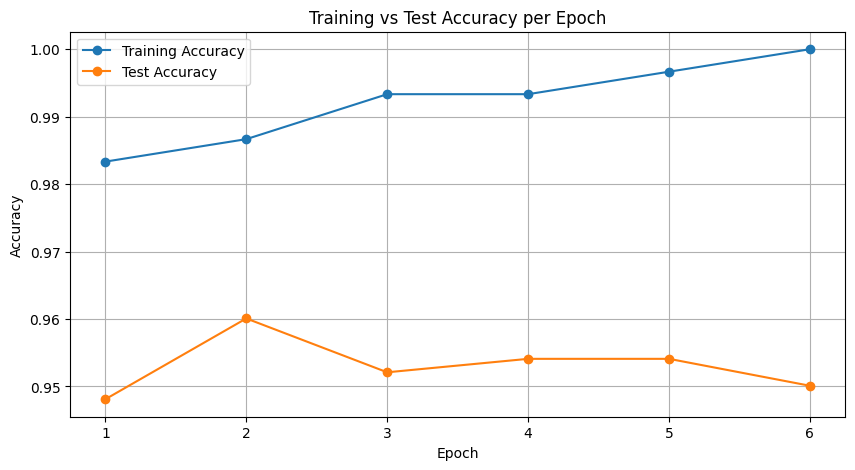

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_acc_history, label='Training Accuracy', marker='o')
plt.plot(range(1, EPOCHS+1), test_acc_history, label='Test Accuracy', marker='o')
plt.title('Training vs Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Running evaluation: Fine-Tuned Model...


100%|██████████| 501/501 [01:04<00:00,  7.78it/s]
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000026793FE6D50>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 7f5aaf7b-9959-4662-a845-f33076e057c6)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch32/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000026793FE6E90>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 0422eaaf-dc4c-47a9-977b-be724d261ed3)')' thrown while requesting HEAD https


Running evaluation: Base Model (Zero-Shot)...


100%|██████████| 501/501 [01:03<00:00,  7.88it/s]


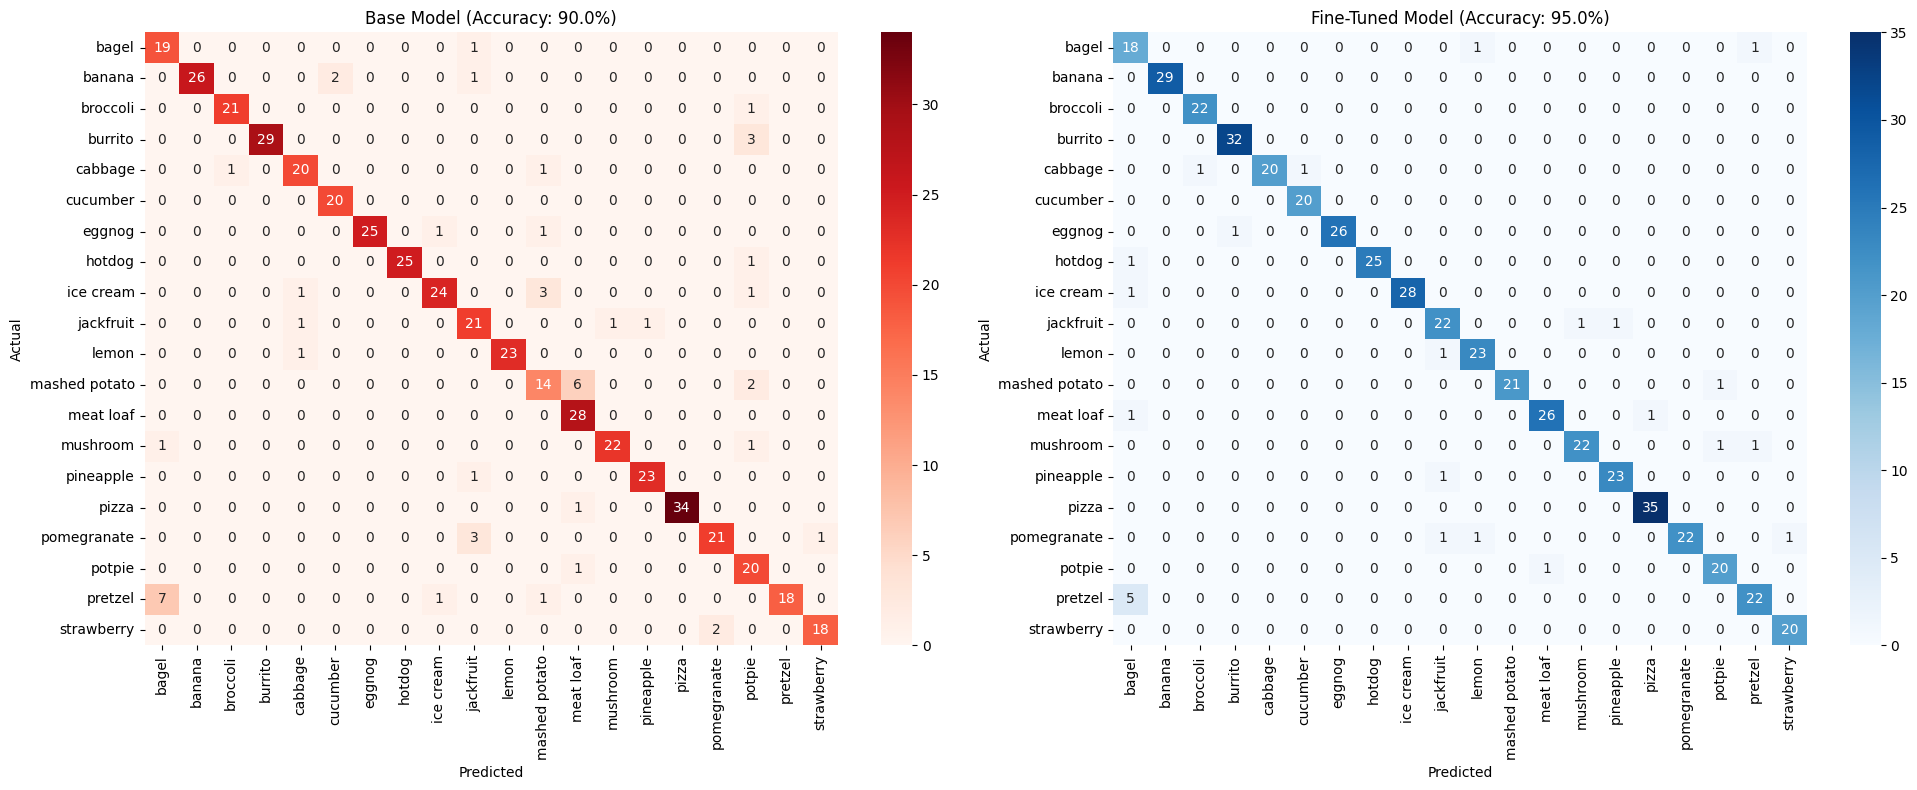

In [6]:
def evaluate_model(model, processor, test_data, classes, title):
    print(f"\nRunning evaluation: {title}...")
    
    text_prompts = [f"a photo of a {c}" for c in classes]
    text_inputs = processor(text=text_prompts, return_tensors="pt", padding=True).to(device)
    
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for item in tqdm(test_data):
            image = Image.open(item["image_path"]).convert("RGB")
            image_inputs = processor(images=image, return_tensors="pt").to(device)
            
            outputs = model(
                input_ids=text_inputs["input_ids"],
                attention_mask=text_inputs["attention_mask"],
                pixel_values=image_inputs["pixel_values"]
            )
            
            probs = outputs.logits_per_image.softmax(dim=1)
            pred_idx = torch.argmax(probs).item()
            
            y_pred.append(classes[pred_idx])
            y_true.append(item["label"])
            
    return y_true, y_pred

y_true_ft, y_pred_ft = evaluate_model(model_ft, processor, test_data, class_names, "Fine-Tuned Model")
model_base = CLIPModel.from_pretrained(MODEL_ID).to(device)
y_true_base, y_pred_base = evaluate_model(model_base, processor, test_data, class_names, "Base Model (Zero-Shot)")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

cm_base = confusion_matrix(y_true_base, y_pred_base, labels=class_names)
acc_base = accuracy_score(y_true_base, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Reds', ax=axes[0], 
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title(f"Base Model (Accuracy: {acc_base*100:.1f}%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

cm_ft = confusion_matrix(y_true_ft, y_pred_ft, labels=class_names)
acc_ft = accuracy_score(y_true_ft, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title(f"Fine-Tuned Model (Accuracy: {acc_ft*100:.1f}%)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()